In [2]:
# All works with Python 3.10.5 64 bits
import os
import rioxarray
import numpy as np
import seaborn as sns
from osgeo import ogr
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import warnings
from pathlib import Path

warnings.filterwarnings("ignore", category=DeprecationWarning)
# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")


Variables

In [9]:
#JUST SET THIS INFO
huge_tile_path='../Tiles\HugeTile46\DOP_CRS3035RES50000mN2800000E4750000_20220128.tif'# Notice about the format of the filename (name defined by https://data.bev.gv.at) No matter the path only the filename
tilenumber=46 # Notice about the format of the filename 'AustriaGridInfo.pdf'

#clip_mode only accepts two values 'a' for create the grid and crop all the image or 'u' for only useful tiles, it needs an extra shape file
clip_mode='u' # if 'u' is not necessary to create te grid, so the code will use the shapefille ↓↓↓ just run the las part of the notebook
useful_tiles_shp = '../Tiles/HugeTile46/tiles/useful/shp/parking_tiles_46.shp' # if 'a' this is not necessary


#Widh and  height of each tile of the grid
tile_width = 500
tile_height = 500

Creating neccessary directories for the resul of clipping

In [11]:

grid_path = os.sep.join(huge_tile_path.split(os.sep)[:-1])+ os.sep + 'grid'
tiles_path= os.sep.join(huge_tile_path.split(os.sep)[:-1])+ os.sep + 'tiles'
grid_shape_file=f"{grid_path + os.sep}HugeTile{tilenumber}_Grid.shp"
Path(grid_path).mkdir(parents=True, exist_ok=True)
Path(tiles_path).mkdir(parents=True, exist_ok=True)


Extracting the data from the tif's filename

In [60]:
def getCoordinates(filename):
    if(not filename):
        raise ValueError()
    y,x = filename.split(os.sep)[-1].split('N')[-1].split('E')
    dim = filename.split('RES')[-1].split('m')[0]
    x=int(x.split('_')[0])
    y=int(y)
    dim =int(dim)
    return [x,y,dim]
    
x,y,dim =getCoordinates(huge_tile_path)
print(x,y,dim)
raster = gdal.Open(huge_tile_path)
print(raster.GetMetadata_List())
print(raster.GetProjectionRef())

4750000 2800000 50000
['AREA_OR_POINT=Area', 'DataType=Generic']
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]


Creating the grid of the Huge Tile

epsg:3035


<AxesSubplot:>

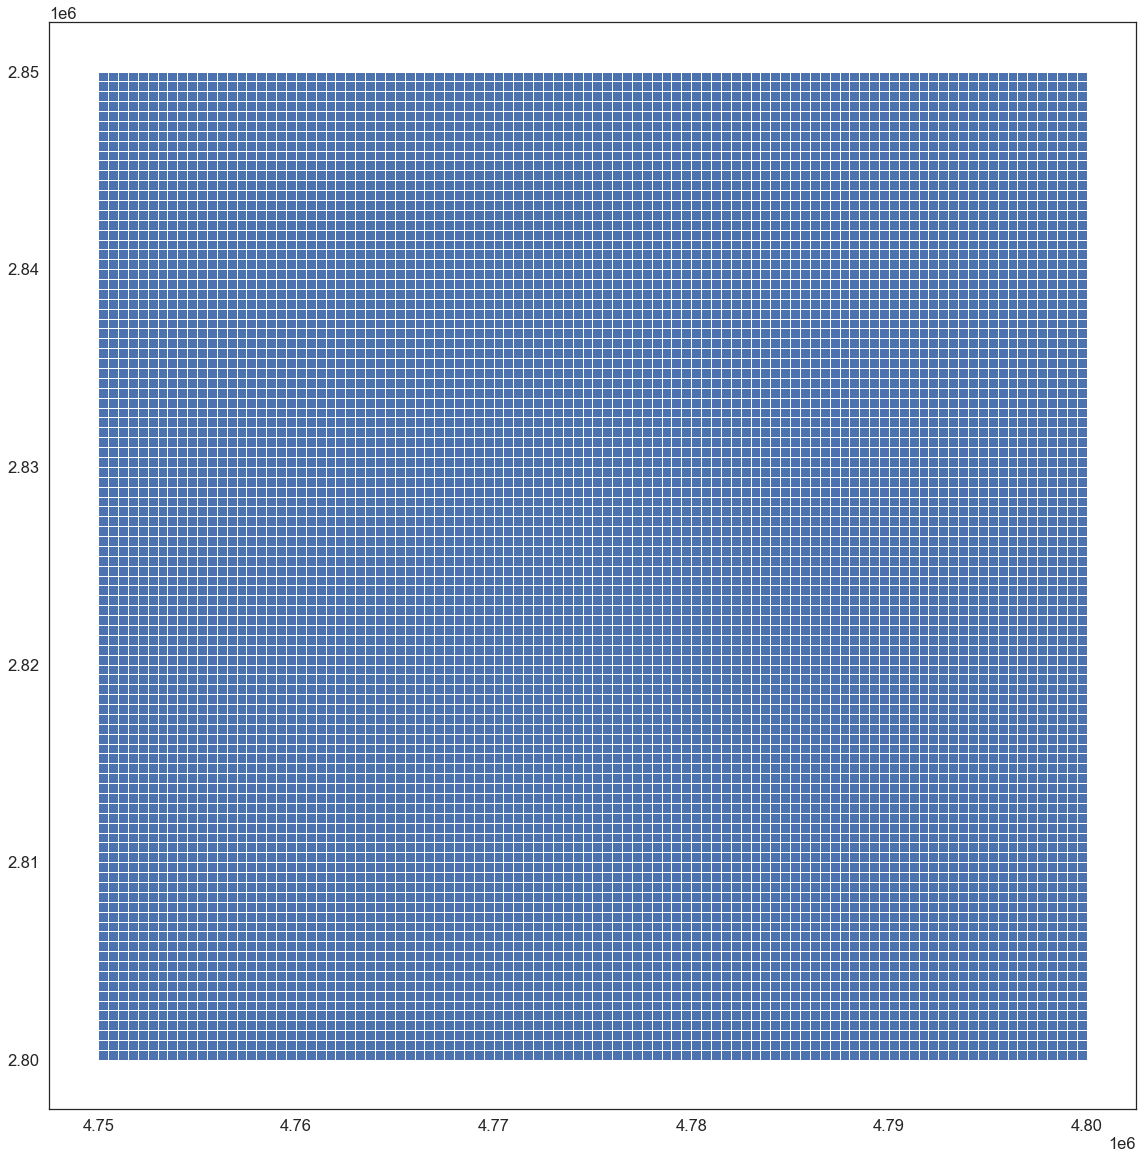

In [64]:
xmin, ymin, xmax, ymax = [x, y, x+dim, y+dim]
width = 500
height = 500
rows = int(np.ceil((ymax-ymin) / height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax - height
cell_number = 0
polygons = []
for i in range(cols):
    Ytop = YtopOrigin
    Ybottom = YbottomOrigin
    for j in range(rows):
        new_Polygon = Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop),
                              (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])
        new_Polygon._crs = "epsg:3035"
        # print(new_Polygon._crs)
        polygons.append(new_Polygon)
        Ytop = Ybottom
        Ybottom = Ybottom - height
        cell_number = cell_number+1
    XleftOrigin = XrightOrigin
    XrightOrigin = XrightOrigin + width
grid = gpd.GeoDataFrame({'geometry': polygons})
grid = grid.set_crs("epsg:3035")
print(grid.crs)
grid.to_file(grid_shape_file)
grid.plot(figsize=(5, 5))


Clipping process

In [13]:
# Open shapefile, if 'a' the code will use the grid file created in the previous annotations, if 'u' the code will use the shapefile provided from the variables
shape_file = ogr.Open(grid_shape_file if (clip_mode=='a') else useful_tiles_shp)
polygon_layer = shape_file.GetLayerByIndex(0)

#if 'a' create the subdirectory tiles/all
extra_tiles_path = ''
if (clip_mode == 'a'):
    extra_tiles_path = tiles_path + os.sep + 'all'
    Path(extra_tiles_path).mkdir(parents=True, exist_ok=True)

#if 'u' create the subdirectory tiles/useful/tif
if (clip_mode == 'u'):
    extra_tiles_path = tiles_path + os.sep + 'useful'+ os.sep + 'tif' 
    Path(extra_tiles_path).mkdir(parents=True, exist_ok=True)

###########################################################FUNCTION TO MAKE THE CLIPPING PROCESS

def cut_by_shape(original_image, shapefile, polygon_value):
    #Set a name for each tile
    fname_out =extra_tiles_path + os.sep +  original_image.split(
        os.sep)[-1].replace(".tif", f"_{int(polygon_value):05}.tif")
    # Do the actual clipping
    g = gdal.Warp(fname_out, original_image, format="GTiff",
                    cutlineDSName=shapefile,
                    cutlineWhere=f"fid={polygon_value:d}",
                    cropToCutline=True)
    # Return the name of the new tile
    return fname_out
###########################################################END OF FUNCTION

# Loop over all the polygons in the grid or the shapefile provided
for polygon in polygon_layer:
    polygon_fid = polygon.GetFieldAsInteger('FID')
    fname_out = cut_by_shape(huge_tile_path, grid_shape_file, polygon_fid)
    print(fname_out)
    


../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00030.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00037.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00061.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00062.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00064.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00131.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00137.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00137.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00160.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750000_20220128_00161.tif
../Tiles\HugeTile46\tiles\useful\tif\DOP_CRS3035RES50000mN2800000E4750